In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info_iso(pars, n_layers, labels, ps, n_copies=1, n_meas=0, dN=1e-5, n_inp=2):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    if n_meas == 0:
        n_meas = n_tot
    n_tot = max(n_inp*n_copies, n_meas)
    n_dif = n_inp*n_copies - n_meas
    d_diff = 2**max(0, n_dif)
            
    pars_ans = pars[:len(pars) - 2**n_meas]
    pars_est = pars[len(pars) - 2**n_meas:]
    
    # CX_cascade = cx_cascade(n_tot)
    # ansatz = hea_cx_rzrx(n_tot, n_layers, CX_cascade, pars_ans)
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    
    projs = [reduce(kron, [diag(line), eye(2**max(0, n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2
    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(ps)): # take a density matrix from the training set
        p = ps[j]
        N = labels[j]
        if p > 1/3:
            dm_n = (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
            dm_n_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
            dm_n_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
            
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            dm_n_p = reduce(kron, [dm_n_p]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            dm_n_m = reduce(kron, [dm_n_m]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [trace((dm_n_p - dm_n_m)@proj).real/(2*dN) for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            
            CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
            QFI = 2*(1 - sqrt(fidelity(dm_n_m, dm_n_p))) / dN**2 + 1e-10 # via centered differences 
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
            
        else:
            dm_n = p*dm_bell + (1 - p)/4*eye(4)
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*(n_meas - n_inp*n_copies))
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [0 for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            CFI = n_copies # placeholder; excluded from the plot
            QFI = n_copies # placeholder; excluded from the plot
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

# Multiple copies

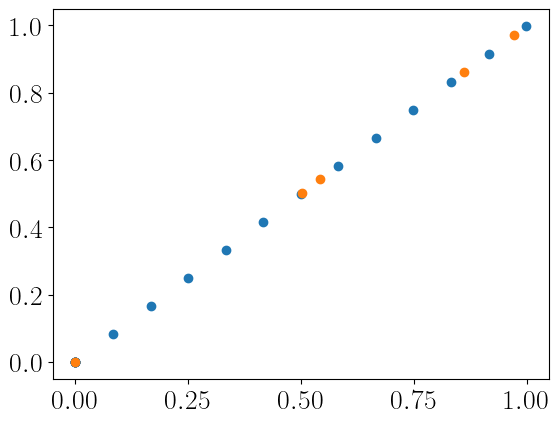

In [3]:
n_inp = 2
n_train = 5
n_test = 19
marks = "neg"

dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2

ps_train = uniform(1e-3, 1 - 1e-3, n_train)
dms_train = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_train]
labels_train = [two_subsys_negativity(dm) for dm in dms_train]

ps_test = linspace(1e-3, 1 - 1e-3, n_test)
dms_test = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_test]
labels_test = [two_subsys_negativity(dm) for dm in dms_test]

dN = 1e-5
dms_check = []
QFIs = []
for N in labels_train:
    dm =   (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
    dm_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
    dm_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences
    QFIs.append(QFI)
    dms_check.append(dm)

plt.scatter(labels_test, labels_test)
plt.scatter(labels_train, labels_train)

In [4]:
w_ls = 1e0
w_var = 1e-4
dN = 1e-5
method = "BFGS"
options = {"maxiter": int(3e3), "maxfun": int(1e10)}##

### 1 copy

In [8]:
n_copies_1 = 1
n_meas_1 = n_inp*n_copies_1
n_tot_1 = n_inp*n_copies_1# + max(0, n_meas_1 - n_inp*n_copies_1)
n_layers_1 = 1
# x0_1 = concatenate([normal(pi/2, 0.1, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), normal(0., 1e-3, 2**n_meas_1)])
# x0_1 = concatenate([normal(0, 1e-1, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), normal(0., 1e-1, 2**n_meas_1)])
x0_1 = concatenate([uniform(0, 2*pi, 3*n_layers_1*n_tot_1 - n_layers_1 + 2*n_tot_1), uniform(-1, 1, 2**n_meas_1)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_1 = time()
fvals_1, result_1 = train(dms_train, labels_train, n_layers_1, method=method, n_copies=n_copies_1, n_meas=n_meas_1,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_1)
time_finish_1 = time() - time_start_1
print("\n\nFinished in", time_finish_1)
print("Cost:", result_1.fun)
print(result_1.message)
pars_1 = result_1.x

expecs_train_1, expecs_der_train_1, disps_train_1, CFIs_train_1, QFIs_train_1 = aux_info_iso(pars_1, n_layers_1, labels_train, ps_train, n_copies=n_copies_1, n_meas=n_meas_1, dN=dN)
expecs_test_1, expecs_der_test_1, disps_test_1, CFIs_test_1, QFIs_test_1 = aux_info_iso(pars_1, n_layers_1, labels_test, ps_test, n_copies=n_copies_1, n_meas=n_meas_1, dN=dN)

Iteration: 181 | Function value: 0.01638112

Finished in 0.708975076675415
Cost: 0.016381116868277194
Optimization terminated successfully.



n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.01284118913572756


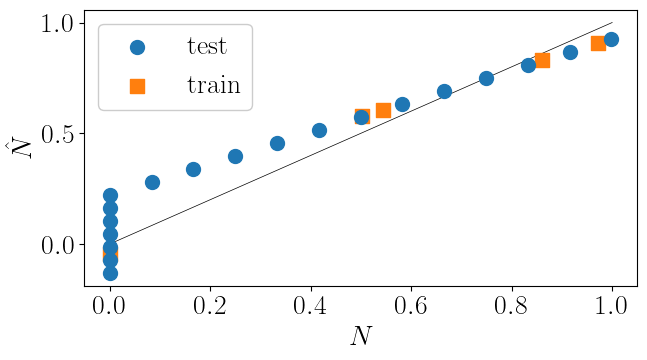

/tmp/ipykernel_2480092/2940386462.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


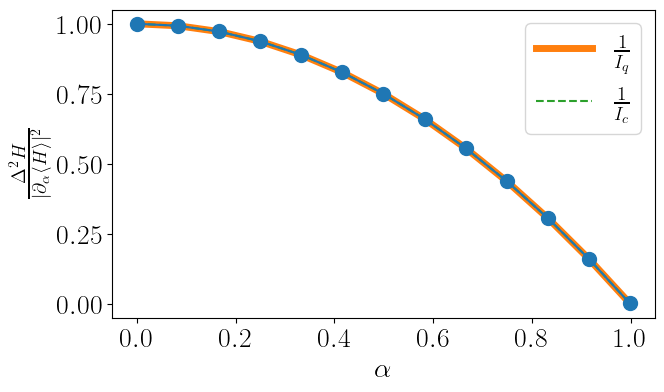

In [9]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_1, n_meas_1, n_layers_1))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_1 = sum(np.abs(labels_test - expecs_test_1)**2)/n_test
print("Sum error:", sum_error_1)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_1, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_1, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, disps_test, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_1, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_1, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.plot(labels_test, [1 - N**2 for N in labels_test])
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

### 2 copies

In [23]:
n_copies_2 = 2
n_layers_2 = 2
n_tot_2 = n_inp*n_copies_2
n_meas_2 = n_inp*n_copies_2

# x0_2 = prev_to_next_ansatz(pars_1, n_tot_1, n_meas_1, n_layers_1, n_tot_2, n_meas_2, n_layers_2, subsval=pi)
# x0_2 = concatenate([normal(pi/2, 0.1, 3*n_layers_2*n_tot_2 - n_layers_2 + 2*n_tot_2), normal(0., 1e-3, 2**n_meas_2)])
x0_2 = concatenate([uniform(0, 2*pi, 3*n_layers_2*n_tot_2 - n_layers_2 + 2*n_tot_2), uniform(-0.5, 0.5, 2**n_meas_2)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_2 = time()
fvals_2, result_2 = train(dms_train, labels_train, n_layers_2, method=method, n_copies=n_copies_2, n_meas=n_meas_2,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_2)
time_finish_2 = time() - time_start_2
print("\n\nFinished in", time_finish_2)
print("Cost:", result_2.fun)
print(result_2.message)
pars_2 = result_2.x

expecs_train_2, expecs_der_train_2, disps_train_2, CFIs_train_2, QFIs_train_2 = aux_info_iso(pars_2, n_layers_2, labels_train, ps_train, n_copies=n_copies_2, n_meas=n_meas_2, dN=dN)
expecs_test_2, expecs_der_test_2, disps_test_2, CFIs_test_2, QFIs_test_2 = aux_info_iso(pars_2, n_layers_2, labels_test, ps_test, n_copies=n_copies_2, n_meas=n_meas_2, dN=dN)

Iteration: 580 | Function value: 0.00020596

Finished in 24.638192892074585
Cost: 0.0002059614084906627
Optimization terminated successfully.


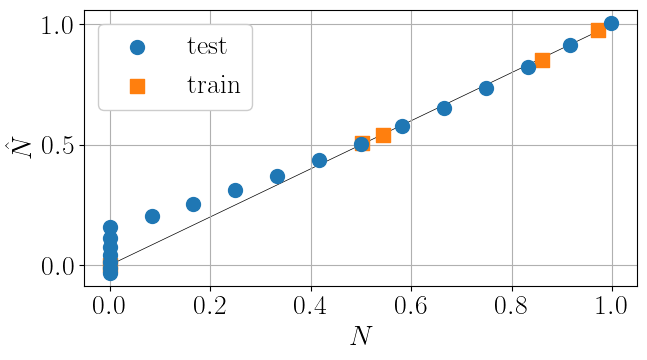

/tmp/ipykernel_2480092/646611261.py:19: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, label=r"$m=2$", s=100, marker="s", color="C1", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


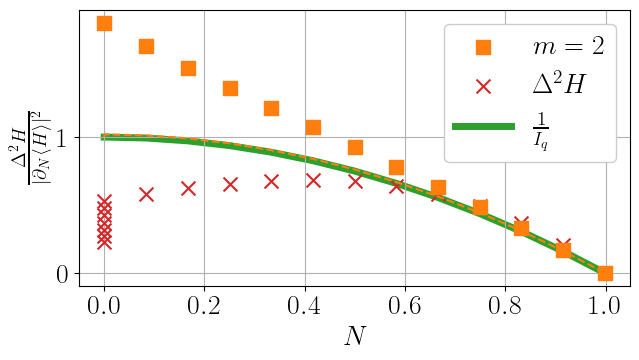

In [24]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_2, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=-1)
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.grid()
# plt.savefig("iso-est-m-test.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, label=r"$m=2$", s=100, marker="s", color="C1", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, n_copies_2*disps_test_2, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, n_copies_2/CFIs_test_2, color="C1", linewidth=1.5, linestyle="--", zorder=7) # , label=r"$\frac{1}{I_c}$"
plt.plot(labels_test, n_copies_2/QFIs_test_2, color="C2", linewidth=5, linestyle="solid", zorder=0, label=r"$\frac{1}{I_q}$") # 
# plt.plot(labels_test, [2 - N - N**2 for N in labels_test], color="C0", linewidth=1.5, linestyle="--", zorder=7)
# plt.plot(labels_test, [1 - N**2 for N in labels_test], color="C1", linewidth=1.5, linestyle="--", zorder=8)
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.legend(framealpha=1)
plt.grid()
# plt.ylim(-0.05, 2.15)
plt.tight_layout()
# plt.savefig("iso-var_red-m-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

### 3 copies

In [25]:
n_copies_3 = 3
n_layers_3 = 2
n_tot_3 = n_inp*n_copies_3
n_meas_3 = n_inp*n_copies_3

# x0_3 = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_3, n_meas_3, n_layers_3, subsval=0)
# x0_3 = concatenate([normal(pi/2, 0.1, 3*n_layers_3*n_tot_3 - n_layers_3 + 2*n_tot_3), normal(0., 1e-3, 2**n_meas_3)])
x0_3 = concatenate([uniform(0, 2*pi, 3*n_layers_3*n_tot_3 - n_layers_3 + 2*n_tot_3), uniform(-0.5, 0.5, 2**n_meas_3)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_3 = time()
fvals_3, result_3 = train(dms_train, labels_train, n_layers_3, method=method, n_copies=n_copies_3, n_meas=n_meas_3,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_3)
time_finish_3 = time() - time_start_3
print("\n\nFinished in", time_finish_3)
print("Cost:", result_3.fun)
print(result_3.message)
pars_3 = result_3.x

expecs_train_3, expecs_der_train_3, disps_train_3, CFIs_train_3, QFIs_train_3 = aux_info_iso(pars_3, n_layers_3, labels_train, ps_train, n_copies=n_copies_3, n_meas=n_meas_3, dN=dN)
expecs_test_3, expecs_der_test_3, disps_test_3, CFIs_test_3, QFIs_test_3 = aux_info_iso(pars_3, n_layers_3, labels_test, ps_test, n_copies=n_copies_3, n_meas=n_meas_3, dN=dN)

Iteration: 1049 | Function value: 0.00008361

Finished in 306.6554925441742
Cost: 8.36134268869911e-05
Optimization terminated successfully.



n_inp: 2 | n_copies: 3 | n_meas: 6 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.0018076693428327973


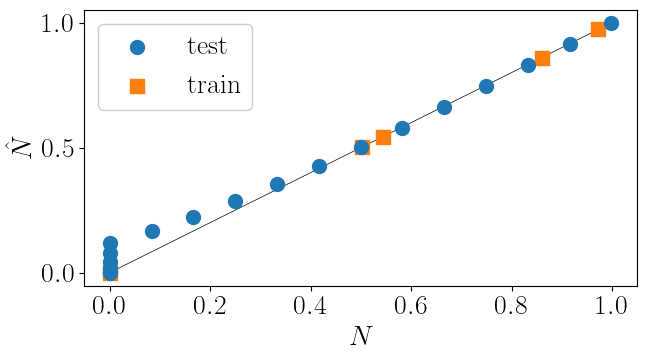

/tmp/ipykernel_2480092/2664093294.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


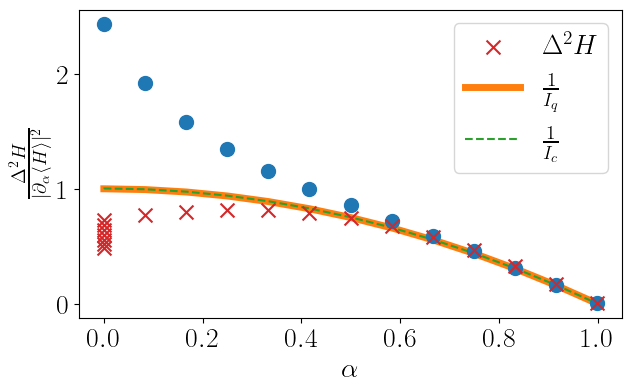

In [26]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_3, n_meas_3, n_layers_3))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_3 = sum(np.abs(labels_test - expecs_test_3)**2)/n_test
print("Sum error:", sum_error_3)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_3, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_3, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, n_copies_3*disps_test_3, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, n_copies_3/QFIs_test_3, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, n_copies_3/CFIs_test_3, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

### 4 copies

In [15]:
n_copies_4 = 4
n_layers_4 = 2
n_tot_4 = n_inp*n_copies_4
n_meas_4 = n_inp*n_copies_4

# x0_4 = prev_to_next_ansatz(pars_3, n_tot_3, n_meas_3, n_layers_3, n_tot_4, n_meas_4, n_layers_4, subsval=0)
# x0_4 = concatenate([normal(pi/2, 0.1, 3*n_layers_4*n_tot_4 - n_layers_4 + 2*n_tot_4), normal(0., 1e-3, 2**n_meas_4)])
x0_4 = concatenate([uniform(0, 2*pi, 3*n_layers_4*n_tot_4 - n_layers_4 + 2*n_tot_4), uniform(-1, 1, 2**n_meas_4)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_4 = time()
fvals_4, result_4 = train(dms_train, labels_train, n_layers_4, method=method, n_copies=n_copies_4, n_meas=n_meas_4,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_4)
time_finish_4 = time() - time_start_4
print("\n\nFinished in", time_finish_4)
print("Cost:", result_4.fun)
print(result_4.message)
pars_4 = result_4.x

expecs_train_4, expecs_der_train_4, disps_train_4, CFIs_train_4, QFIs_train_4 = aux_info_iso(pars_4, n_layers_4, labels_train, ps_train, n_copies=n_copies_4, n_meas=n_meas_4, dN=dN)
expecs_test_4, expecs_der_test_4, disps_test_4, CFIs_test_4, QFIs_test_4 = aux_info_iso(pars_4, n_layers_4, labels_test, ps_test, n_copies=n_copies_4, n_meas=n_meas_4, dN=dN)

In [42]:
pars_4

array([ 4.78681717e+00,  1.82162505e+00,  5.03088977e+00,  2.31244456e+00,
        5.70109642e+00,  1.49921687e+00,  8.40363630e-01,  7.45715286e-01,
        2.39824062e+00,  2.94759721e+00,  5.46721545e+00,  9.10569889e-01,
       -3.77599809e-01,  6.47086972e+00,  4.58629488e-01,  4.75389764e+00,
        4.70608688e+00,  6.26646311e+00,  1.64905807e+00, -9.13226747e-03,
        1.56964562e+00,  1.60502209e+00,  4.77474083e+00,  2.70525384e+00,
        4.50631165e+00,  3.41452121e+00,  6.54732846e-01,  8.24202842e-01,
        1.29828448e+00,  5.73963422e+00,  1.88652210e+00,  8.22370810e-01,
        2.38447163e+00,  4.70916048e+00, -1.76972613e+00,  4.23276221e-01,
        2.42867315e+00,  4.03679684e-01,  3.21253327e+00, -1.61954943e-01,
        6.24277915e+00,  2.40488502e+00, -5.01440237e-02,  6.29989158e+00,
        7.11208936e+00,  2.81060019e+00,  4.13732666e-01,  4.25776269e+00,
        4.26393001e+00,  4.36164643e+00,  1.41327255e+00,  3.66055603e-01,
        2.57808841e+00,  


n_inp: 2 | n_copies: 4 | n_meas: 8 | n_layers: 2 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 0.012156567171085486


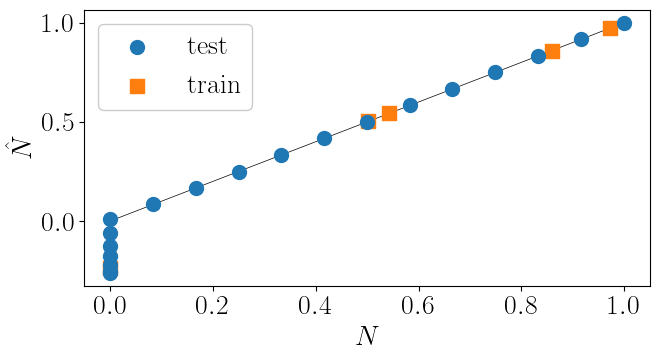

/tmp/ipykernel_2480092/685812226.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


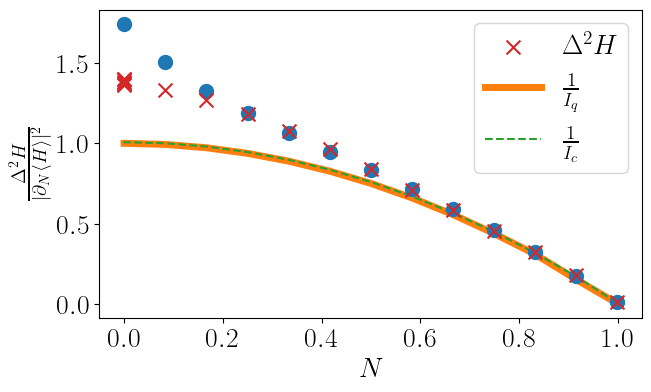

In [18]:
print()
print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies_4, n_meas_4, n_layers_4))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_4 = sum(np.abs(labels_test - expecs_test_4)**2)/n_test
print("Sum error:", sum_error_4)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_4, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_4, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, n_copies_4*disps_test_4, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, n_copies_4*1/QFIs_test_4, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, n_copies_4*1/CFIs_test_4, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.legend()
# plt.yscale("log")
plt.show()

In [19]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/Negativity/"

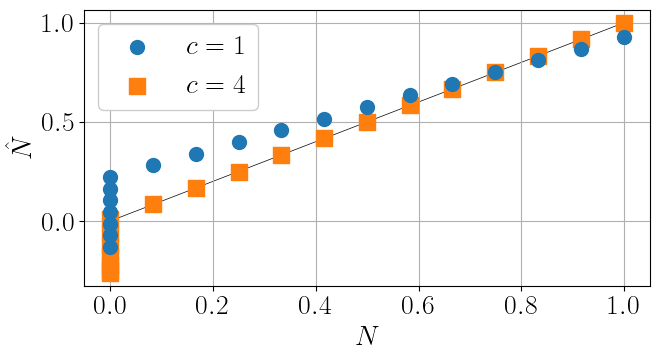

/tmp/ipykernel_2480092/3894820508.py:20: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", label=r"$c=1$", zorder=10) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
/tmp/ipykernel_2480092/3894820508.py:23: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=120, marker="s", label=r"$c=4$", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"


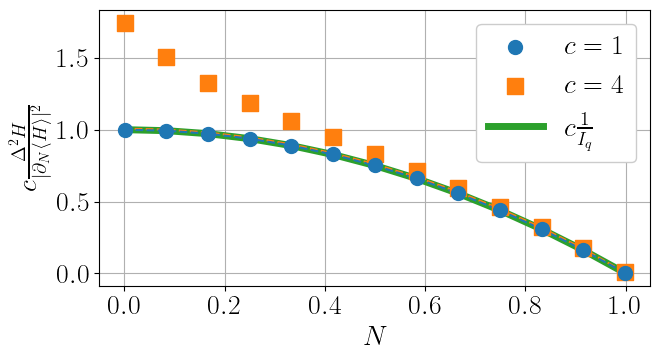

In [20]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, marker='o', s=100, label=r"$c=1$", zorder=10)#, $E={}$".format(sum_error_1))
# plt.scatter(labels_test, expecs_test_2, marker='^', s=100, label=r"$c=2$")#, $E={}$".format(sum_error_2))
# plt.scatter(labels_test, expecs_test_3, marker='x', s=100, label=r"$c=3$")#, $E={}$".format(sum_error_3))
plt.scatter(labels_test, expecs_test_4, marker='s', s=120, label=r"$c=4$", zorder=9)#, $E={}$".format(sum_error_4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=-1)
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + "iso-est-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, s=100, marker="o", label=r"$c=1$", zorder=10) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, n_copies_2*disps_test_2/expecs_der_test_2**2, s=100, marker="^", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.scatter(labels_test, n_copies_3*disps_test_3/expecs_der_test_3**2, s=100, marker="x", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, n_copies_4*disps_test_4/expecs_der_test_4**2, s=120, marker="s", label=r"$c=4$", zorder=9) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
# plt.plot(labels_test, n_copies_4*1/QFIs_test_4, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, array([(1 - N**2) for N in labels_test]), color="C2", linewidth=5, linestyle="solid", label=r"$c\frac{1}{I_q}$") # , color="tab:blue", label=r"$c\frac{1}{I_q}$"
plt.plot(labels_test, n_copies_1*1/CFIs_test_1, color="C0", linewidth=1.5, linestyle="dashed", zorder=8) # , color="tab:red", label=r"$c\frac{1}{I_c}$"
plt.plot(labels_test, n_copies_4*1/CFIs_test_4, color="C1", linewidth=1.5, linestyle="dashed", zorder=7) # , color="tab:red", label=r"$c\frac{1}{I_c}$"
plt.ylabel(r"$c\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
plt.legend(ncol=1, framealpha=1)
plt.grid()
# plt.yscale("log")
plt.tight_layout()
# plt.savefig(save_path + "iso-var-test.pdf", transparent=True, bbox_inches='tight')
plt.show()

# Different number of measured qubits, extension

In [7]:
def aux_info_iso_naimark(pars, n_layers, labels, ps, n_copies=1, n_ext=1, dN=1e-5, n_inp=2):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies + n_ext
            
    pars_ans = pars[:len(pars) - 2**n_ext]
    pars_est = pars[len(pars) - 2**n_ext:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    
    projs = [reduce(kron, [eye(2**n_inp), diag(line)]) for line in eye(2**n_ext)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
    

    dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2
    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(ps)): # take a density matrix from the training set
        p = ps[j]
        N = labels[j]
        if p > 1/3:
            dm_n = (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
            dm_n_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
            dm_n_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
            
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*n_ext)
            dm_n_p = reduce(kron, [dm_n_p]*n_copies + [P0]*n_ext)
            dm_n_m = reduce(kron, [dm_n_m]*n_copies + [P0]*n_ext)
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [trace((dm_n_p - dm_n_m)@proj).real/(2*dN) for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            
            CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
            QFI = 2*(1 - sqrt(fidelity(dm_n_m, dm_n_p))) / dN**2 + 1e-10 # via centered differences 
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
            
        else:
            dm_n = p*dm_bell + (1 - p)/4*eye(4)
            dm_n = reduce(kron, [dm_n]*n_copies + [P0]*n_ext)
            
            probs = [trace(dm_n@proj).real for proj in projs_u]
            probs_der = [0 for proj in projs_u]
            
            expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
            expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
            
            disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
            CFI = n_copies # placeholder; excluded from the plot
            QFI = n_copies # placeholder; excluded from the plot
            
            expecs.append(expec)
            expecs_der.append(expec_der)
            disps.append(disp)
            CFIs.append(CFI)
            QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [8]:
n_inp = 2
n_train = 5
n_test = 15
marks = "neg"

dm_bell = array([[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]])/2

ps_train = uniform(1/3 + 1e-3, 1 - 1e-3, n_train)
dms_train = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_train]
labels_train = [two_subsys_negativity(dm) for dm in dms_train]

ps_test = linspace(1/3 + 1e-3, 1 - 1e-3, n_test)
dms_test = [p*dm_bell + (1 - p)/4*eye(4) for p in ps_test]
labels_test = [two_subsys_negativity(dm) for dm in dms_test]

dN = 1e-5
dms_check = []
QFIs = []
for N in labels_train:
    dm =   (2*N + 1)/3*dm_bell + (1 - N)/6*eye(4)
    dm_p = (2*(N + dN) + 1)/3*dm_bell + (1 - (N + dN))/6*eye(4)
    dm_m = (2*(N - dN) + 1)/3*dm_bell + (1 - (N - dN))/6*eye(4)
    QFI = 2*(1 - sqrt(fidelity(dm_m, dm_p))) / dN**2 + 1e-10 # via centered differences
    QFIs.append(QFI)
    dms_check.append(dm)

In [9]:
w_ls = 1e0
w_var = 1e-4
dN = 1e-5
method = "BFGS"
options = {"maxiter": int(3e3), "maxfun": int(1e10)}##

In [10]:
n_copies = 1
n_tot = n_inp*n_copies

Iteration: 85 | Function value: 0.00067471

Finished in 0.28904008865356445
Cost: 0.0006747054809988589
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 4.424658125359763e-07


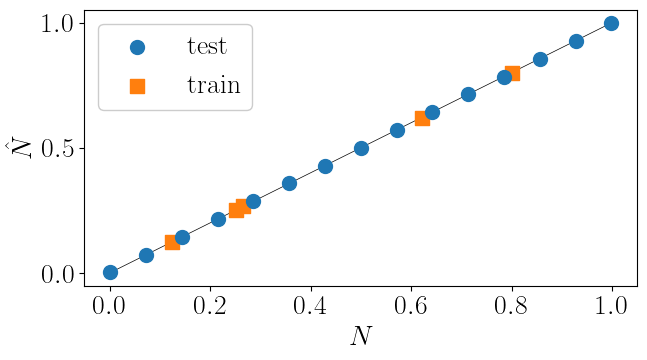

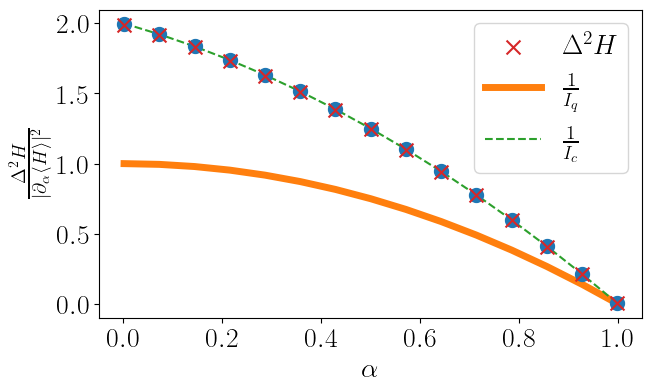

In [11]:
n_layers_1m = 1
n_meas_1m = 1

# x0_1m = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_1m, n_meas_1m, n_layers_1m, subsval=0)
# x0_1m = concatenate([normal(pi/6, 1e-3, 3*n_layers_1m*n_tot - n_layers_1m + 2*n_tot), normal(0., 1e-3, 2**n_meas_1m)])
x0_1m = concatenate([uniform(0, 2*pi, 3*n_layers_1m*n_tot - n_layers_1m + 2*n_tot), uniform(-1, 1, 2**n_meas_1m)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_1m = time()
fvals_1m, result_1m = train(dms_train, labels_train, n_layers_1m, method=method, n_copies=n_copies, n_meas=n_meas_1m,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_1m)
time_finish_1m = time() - time_start_1m
print("\n\nFinished in", time_finish_1m)
print("Cost:", result_1m.fun)
print(result_1m.message)
pars_1m = result_1m.x

expecs_train_1m, expecs_der_train_1m, disps_train_1m, CFIs_train_1m, QFIs_train_1m = aux_info_iso(pars_1m, n_layers_1m, labels_train, ps_train, n_copies=n_copies, n_meas=n_meas_1m, dN=dN)
expecs_test_1m, expecs_der_test_1m, disps_test_1m, CFIs_test_1m, QFIs_test_1m = aux_info_iso(pars_1m, n_layers_1m, labels_test, ps_test, n_copies=n_copies, n_meas=n_meas_1m, dN=dN)

print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_1m, n_layers_1m))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_1m = sum(np.abs(labels_test - expecs_test_1m)**2)/n_test
print("Sum error:", sum_error_1m)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_1m, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_1m, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_1m/expecs_der_test_1m**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_1m, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_1m, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_1m, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

Iteration: 115 | Function value: 0.00038198

Finished in 0.433790922164917
Cost: 0.00038198075588276304
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 2 | n_layers: 1 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 1.4179413612449547e-07


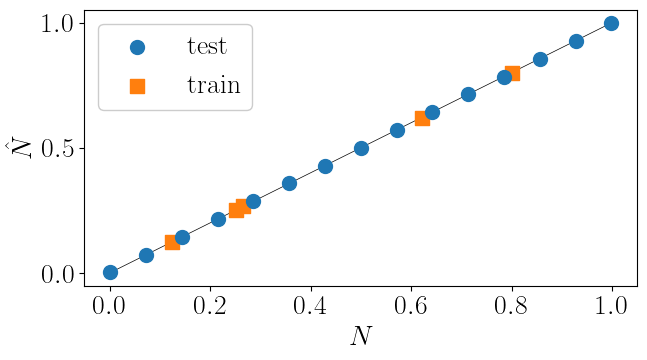

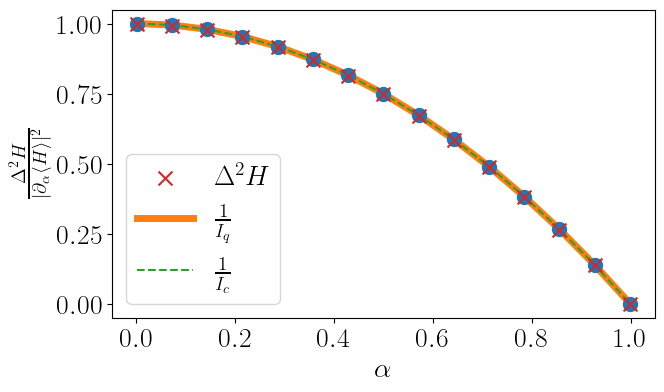

In [12]:
n_layers_2m = 1
n_meas_2m = 2

# x0_2m = prev_to_next_ansatz(pars_2, n_tot_2, n_meas_2, n_layers_2, n_tot_2m, n_meas_2m, n_layers_2m, subsval=0)
# x0_2m = concatenate([normal(pi/6, 1e-3, 3*n_layers_2m*n_tot - n_layers_2m + 2*n_tot), normal(0., 1e-3, 2**n_meas_2m)])
x0_2m = concatenate([uniform(0, 2*pi, 3*n_layers_2m*n_tot - n_layers_2m + 2*n_tot), uniform(-1, 1, 2**n_meas_2m)]) # 2*n_tot*(n_layers + 1))
# x0 = array(pars)
# x0 = None

time_start_2m = time()
fvals_2m, result_2m = train(dms_train, labels_train, n_layers_2m, method=method, n_copies=n_copies, n_meas=n_meas_2m,
                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_2m)
time_finish_2m = time() - time_start_2m
print("\n\nFinished in", time_finish_2m)
print("Cost:", result_2m.fun)
print(result_2m.message)
pars_2m = result_2m.x

expecs_train_2m, expecs_der_train_2m, disps_train_2m, CFIs_train_2m, QFIs_train_2m = aux_info_iso(pars_2m, n_layers_2m, labels_train, ps_train, n_copies=n_copies, n_meas=n_meas_2m, dN=dN)
expecs_test_2m, expecs_der_test_2m, disps_test_2m, CFIs_test_2m, QFIs_test_2m = aux_info_iso(pars_2m, n_layers_2m, labels_test, ps_test, n_copies=n_copies, n_meas=n_meas_2m, dN=dN)

print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_meas_2m, n_layers_2m))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_2m = sum(np.abs(labels_test - expecs_test_2m)**2)/n_test
print("Sum error:", sum_error_2m)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_2m, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_2m, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_2m/expecs_der_test_2m**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_2m, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_2m, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_2m, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

/home/kardashin/Work/QPE/qpe.py:852: OptimizeWarning: Unknown solver options: maxfun
  optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)


Iteration: 926 | Function value: 0.00038199

Finished in 20.983268976211548
Cost: 0.00038199297705993003
Optimization terminated successfully.
n_inp: 2 | n_copies: 1 | n_meas: 1 | n_layers: 3 
w_ls: 1.000000 | w_var: 0.000100 
Sum error: 1.4238378683205114e-07


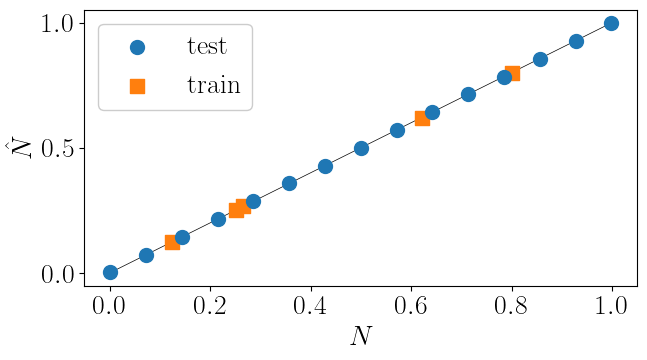

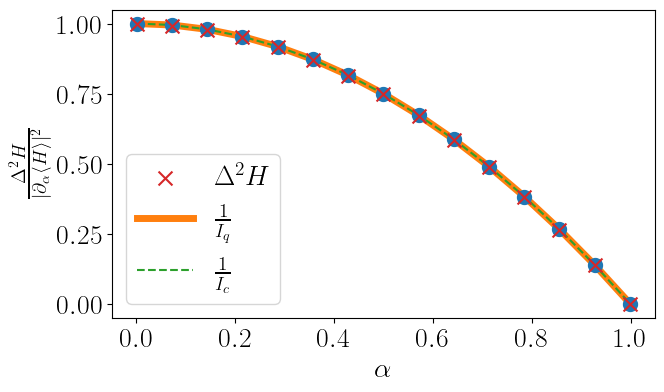

In [13]:
n_layers_ext = 3
n_ext = 1
n_tot_ext = n_inp*n_copies + n_ext

x0_ext = concatenate([uniform(0, 2*pi, 3*n_layers_ext*n_tot_ext - n_layers_ext + 2*n_tot_ext), uniform(-0.1, 0.1, 2**n_ext)]) # 2*n_tot*(n_layers + 1))

time_start_ext = time()
fvals_ext, result_ext = train_naimark(dms_train, labels_train, n_layers_ext, method=method, n_copies=n_copies, n_ext=n_ext,
                                      w_ls=w_ls, w_var=w_var, options=options, x0=x0_ext)
time_finish_ext = time() - time_start_ext
print("\n\nFinished in", time_finish_ext)
print("Cost:", result_ext.fun)
print(result_ext.message)
pars_ext = result_ext.x


expecs_train_ext, expecs_der_train_ext, disps_train_ext, CFIs_train_ext, QFIs_train_ext = aux_info_iso_naimark(pars_ext, n_layers_ext, labels_train, ps_train, n_copies=n_copies, n_ext=n_ext, dN=dN)
expecs_test_ext, expecs_der_test_ext, disps_test_ext, CFIs_test_ext, QFIs_test_ext = aux_info_iso_naimark(pars_ext, n_layers_ext, labels_test, ps_test, n_copies=n_copies, n_ext=n_ext, dN=dN)


print("n_inp: %d | n_copies: %d | n_meas: %d | n_layers: %d " %(n_inp, n_copies, n_ext, n_layers_ext))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))
sum_error_ext = sum(np.abs(labels_test - expecs_test_ext)**2)/n_test
print("Sum error:", sum_error_ext)

plt.figure(figsize=(7, 4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5)
plt.scatter(labels_test, expecs_test_ext, s=100, label=r"test", zorder=4) # , color="tab:cyan"
plt.scatter(labels_train, expecs_train_ext, marker="s", s=100, label=r"train", zorder=3) # , color="tab:cyan"
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, disps_test_ext/expecs_der_test_ext**2, s=100, marker="o", color="C0", zorder=3) # , label=r"$\frac{\Delta^2_\alpha H}{|\partial_\alpha \langle H \rangle |^2}$"
plt.scatter(labels_test, disps_test_ext, marker="x", s=100, color="C3", label=r"$\Delta^2 H$", zorder=4)
plt.plot(labels_test, 1/QFIs_test_ext, color="C1", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
plt.plot(labels_test, 1/CFIs_test_ext, color="C2", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"

plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_\alpha \langle H \rangle |^2}$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

In [14]:
save_path = r"/home/kardashin/Work/QPE/Results/Entanglement/Negativity/"

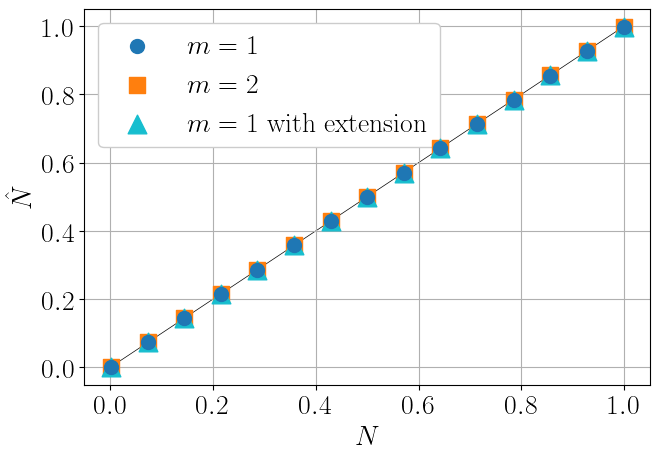

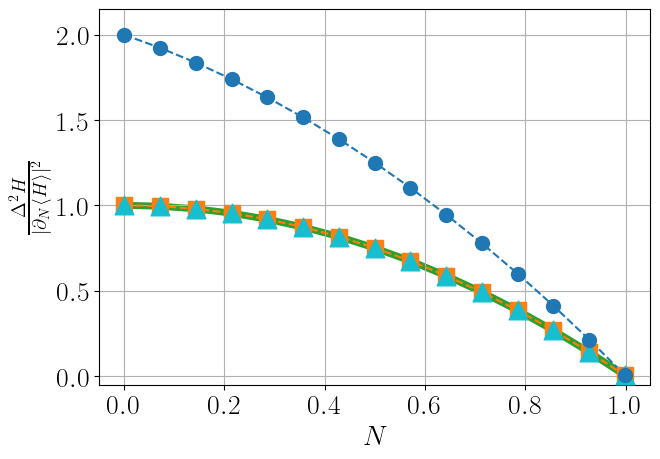

In [16]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1m, marker='o', s=100, label=r"$m=1$", zorder=10)#, $E={}$".format(sum_error_1))
plt.scatter(labels_test, expecs_test_2m, marker='s', s=120, label=r"$m=2$", zorder=8)#, $E={}$".format(sum_error_4))
plt.scatter(labels_test, expecs_test_ext, marker='^', color="tab:cyan", s=180, label=r"$m=1$ with extension", zorder=9)#, $E={}$".format(sum_error_4))
plt.plot([0, 1], [0, 1], color="black", linewidth=0.5, zorder=-1)
plt.ylabel(r"$\hat{N}$" )
plt.xlabel(r"$N$")
plt.legend(framealpha=1)#
plt.tight_layout()
plt.grid()
# plt.savefig(save_path + "iso-est-m-test-trunc-ext.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1m/expecs_der_test_1m**2, s=100, marker="o", color=None, zorder=10) # , label=r"$m=1$"
plt.scatter(labels_test, disps_test_2m/expecs_der_test_2m**2, s=120, marker="s", color="C1", zorder=9) # , label=r"$m=2$"
plt.scatter(labels_test, disps_test_2m/expecs_der_test_ext**2, s=180, marker="^", color="tab:cyan", zorder=9) # , label=r"$m=1$ with extension"
# plt.plot(labels_test, 1/CFIs_test_1m, color="C0", linewidth=1.5, linestyle="--", zorder=8) # , label=r"$\frac{1}{I_c}$"
# plt.plot(labels_test, 1/CFIs_test_2m, color="C1", linewidth=1.5, linestyle="--", zorder=7) # , label=r"$\frac{1}{I_c}$"
plt.plot(labels_test, 1/QFIs_test_2m, color="C2", linewidth=5, linestyle="solid", zorder=0, label=r"$\frac{1}{I_q}$") # 
plt.plot(labels_test, [2 - N - N**2 for N in labels_test], color="C0", linewidth=1.5, linestyle="--", zorder=7)
plt.plot(labels_test, [1 - N**2 for N in labels_test], color="C1", linewidth=1.5, linestyle="--", zorder=8)
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_N \langle H \rangle |^2}$")
plt.xlabel(r"$N$")
# plt.legend(framealpha=1, bbox_to_anchor=(1., 0.75))
plt.grid()
plt.ylim(-0.05, 2.15)
plt.tight_layout()
# plt.savefig(save_path + "iso-var-m-test-trunc-ext.pdf", transparent=True, bbox_inches='tight')
plt.show()